In [1]:
#Import numpy, pandas, data
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

#Data
tickers = ['SPY', 'IEF']
px = yf.download(
    tickers,
    start='2005-01-01', end='2025-01-01',
    interval='1mo',
    auto_adjust=False,
    progress=False
)['Close'].dropna()
px.columns = tickers

#Monthly simple returns
ret = (px/px.shift(1)-1).dropna()
ret.columns = ['Equity', 'Bond']

#3M T-Bill (TB3MS), monthly simple return
tbill = pdr.DataReader('TB3MS', 'fred', start='2005-01-01', end='2025-01-01').dropna()
cash_ret = ((tbill['TB3MS']/100)/12).rename('Cash')

#Merge returns
returns_df = ret.join(cash_ret, how='inner')
print(returns_df.head())

              Equity      Bond      Cash
2005-02-01 -0.016688  0.020904  0.002117
2005-03-01 -0.006765 -0.022134  0.002283
2005-04-01  0.021747 -0.018735  0.002317
2005-05-01  0.015203  0.032225  0.002367
2005-06-01  0.001728 -0.002511  0.002475


In [2]:
#Portfolio definition - edit to change weights
assert list(returns_df.columns) == ['Equity', 'Bond', 'Cash']  #ensure column order
portfolio_weights = np.array([0.60, 0.35, 0.05])  #equity, bond, cash (sum to 1)

#Mean vector and covariance matrix (monthly)
mu = returns_df.mean().values
sigma = returns_df.cov().values


In [3]:
#Monte Carlo with monthly rebalancing
def simulate_paths_simple(mean_returns, cov_matrix, portfolio_weights,
                          horizon_months=120, n_paths=10_000):
    rng = np.random.default_rng()
    asset_returns = rng.multivariate_normal(
        mean=mean_returns,
        cov=cov_matrix,
        size=(horizon_months, n_paths))
    #Portfolio simple returns each month (rebalance monthly)
    portfolio_returns = asset_returns@portfolio_weights  #(months, paths)
    #Cumulative wealth paths (start = 1)
    portfolio_wealth = np.cumprod(1+portfolio_returns, axis=0)
    return portfolio_wealth, portfolio_returns

#Run simulation
portfolio_wealth, portfolio_returns = simulate_paths_simple(
    mean_returns=mu,
    cov_matrix=sigma,
    portfolio_weights=portfolio_weights)


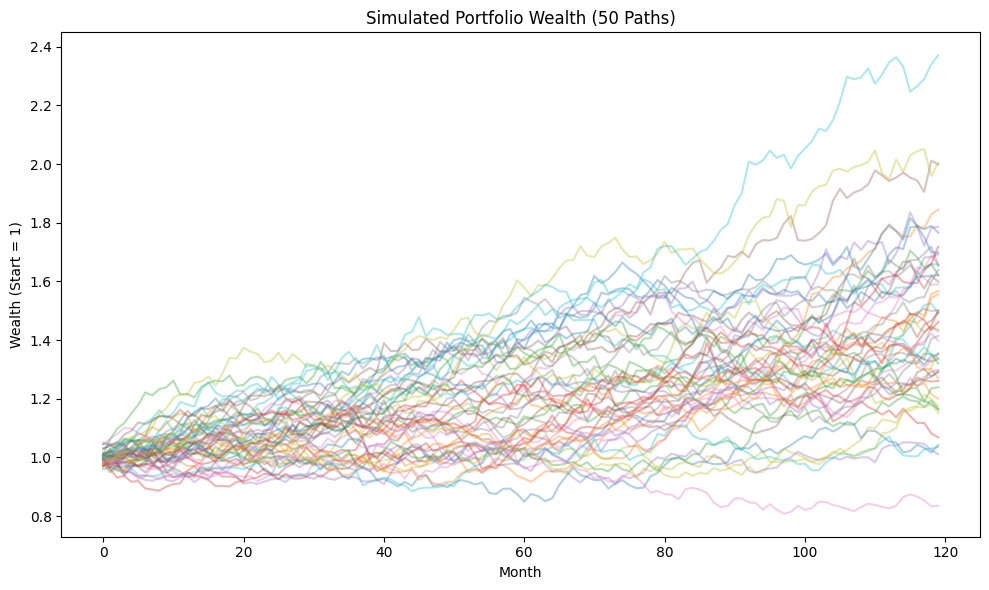

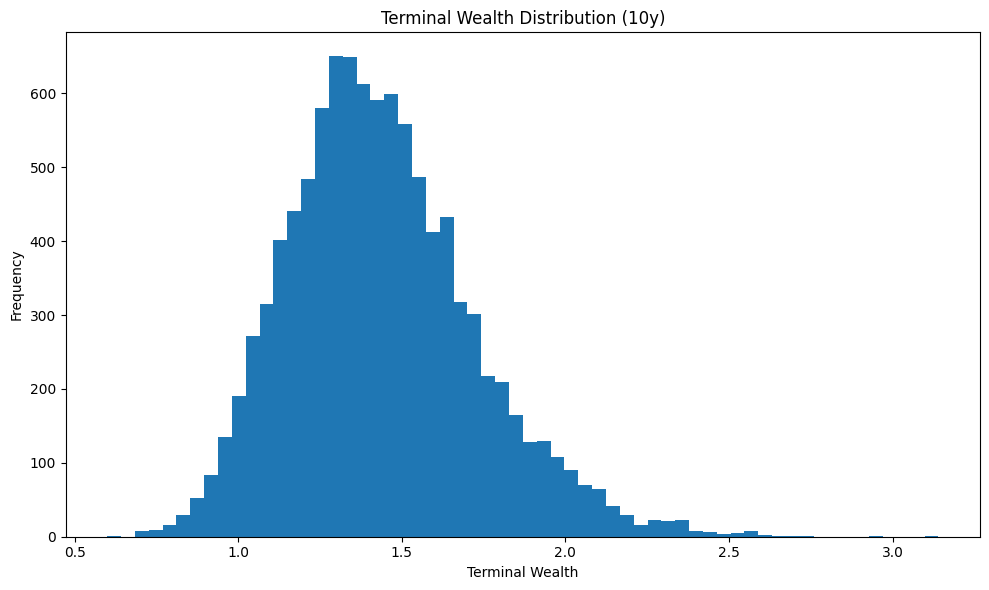

In [4]:
#Plot results
months = portfolio_wealth.shape[0]
rng = np.random.default_rng(123)
idx = rng.choice(portfolio_wealth.shape[1], size=50, replace=False)

plt.figure(figsize=(10, 6))
plt.plot(range(months), portfolio_wealth[:, idx], alpha=0.35)
plt.title("Simulated Portfolio Wealth (50 Paths)")
plt.xlabel("Month")
plt.ylabel("Wealth (Start = 1)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(portfolio_wealth[-1, :], bins=60)
plt.title("Terminal Wealth Distribution (10y)")
plt.xlabel("Terminal Wealth")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [5]:
#Max drawdown
peaks = np.maximum.accumulate(portfolio_wealth, axis=0)
drawdowns = 1-portfolio_wealth/peaks
mdd_median = float(np.median(drawdowns.max(axis=0)))  #max over time, median over paths

#1-year VaR at 5% (95% VaR)
alpha = 0.05
months_total = months
if months_total >= 12:
    one_year = np.prod(1+portfolio_returns[-12:, :], axis=0)-1
    var_1y = float(np.percentile(one_year, 100*alpha))
else:
    var_1y = float("nan")

print("Risk metrics:")
print(f"Median Max Drawdown:{100*mdd_median:.2f}%")
print(f"1-Year 95% VaR:{100*var_1y:.2f}%")

Risk metrics:
Median Max Drawdown:11.67%
1-Year 95% VaR:-6.76%
